In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import pydot
import graphviz
import math
import scipy as sp
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten, Dropout, Conv2D, MaxPooling1D

from ipynb.fs.full.functions import *

2022-07-12 16:01:19.549234: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-12 16:01:19.567256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 16:01:19.567269: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Define variables that are required to simulate stock price
r = 0.00
sig = 0.2
sigtwo = sig**2
T = 30/365
M = 6000
N = 50
S0 = 100
K = 97

In [3]:
# This is used later for the NN model
Si = brownian_motion(N, M, r, T, sig, S0) # Useful to define this for future projects

In [4]:
Sm, S_avg = AverageSequence(Si)

## Stock price generation

Check if this follows geometric Brownian motion

In [5]:
asiancall = MonteCarloAsianOption(S0, K, r, sig, T, M,N )
asiancall

3.9875410082416844

## Arithmetic average with variance reduction techniques

In [6]:
controlvariate, controlstd = MonteCarloGeomControlVariateCall(S0, K, r, sig, T, M,N)
controlvariate

4.032048824186597

# Comparison with GeomAsian

In [7]:
geomprice = GeomAsianCall(S0, K, r, sig, T, M,N)
geomprice

2.870446386169661

## Deep Hedging

In [8]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
my_input = my_input + [premium]

hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
my_input = my_input + [hedge_cost]

price = tf.keras.layers.Input(shape=(1,), name="price")
my_input = my_input + [price] # Asset price

for j in range(N):
    
    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dropout(0.5)(delta)
    delta = tf.keras.layers.Dense(32, activation='relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.Dense(1, activation='sigmoid')(delta)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="multiply_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price

S_average = tf.keras.layers.Input(shape=(1,), name="S_average")
my_input = my_input + [S_average]
    
payoff = tf.keras.layers.Lambda(lambda x : (tf.math.maximum(x-K, 0)))(S_average)  
cum_cost = tf.keras.layers.Add(name="final")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="final_")([cum_cost, premium])

nnmodel = tf.keras.Model(inputs=my_input, outputs=cum_cost)
# nnmodel.summary()
# tf.keras.utils.plot_nnmodel(nnmodel)

2022-07-12 16:01:29.342592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-12 16:01:29.342612: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-12 16:01:29.342629: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ChamberOfSecrets): /proc/driver/nvidia/version does not exist
2022-07-12 16:01:29.343034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
Pi = asiancall * np.ones([M,1]) 
cost = np.zeros([M,1])
SS = [Si[:,i].reshape(M,1) for i in range(N+1)] 
S_a = np.array(S_avg).reshape(M,1) # Here add the average price from the entire run from each simulation.
x = [Pi]+[cost]+[SS]+[S_a] # Premium, hedge_cost, price
y = np.zeros([M,1]) 

In [10]:
nnmodel.compile(loss='mse', optimizer='adam', metrics = 'accuracy')

In [11]:
modelhistory = nnmodel.fit(x,y, epochs=30, verbose=True)

Epoch 1/30
188/188 [==============================] - 42s 40ms/step - loss: 3.5317 - accuracy: 0.6478
Epoch 2/30
188/188 [==============================] - 8s 41ms/step - loss: 1.0339 - accuracy: 0.7315
Epoch 3/30
188/188 [==============================] - 131s 698ms/step - loss: 0.8231 - accuracy: 0.7427
Epoch 4/30
188/188 [==============================] - 8s 42ms/step - loss: 0.8128 - accuracy: 0.7528
Epoch 5/30
188/188 [==============================] - 11s 58ms/step - loss: 0.7568 - accuracy: 0.7587
Epoch 6/30
188/188 [==============================] - 11s 58ms/step - loss: 0.7452 - accuracy: 0.7648
Epoch 7/30
188/188 [==============================] - 9s 49ms/step - loss: 0.7148 - accuracy: 0.7657
Epoch 8/30
188/188 [==============================] - 7s 37ms/step - loss: 0.7168 - accuracy: 0.7593
Epoch 9/30
188/188 [==============================] - 7s 37ms/step - loss: 0.6882 - accuracy: 0.7700
Epoch 10/30
188/188 [==============================] - 6s 34ms/step - loss: 0.7029 - 

188/188 [==============================] - 2s 10ms/step


(array([  7.,   5.,  23.,  61., 151., 256., 405., 554., 617., 698., 600.,
        554., 460., 379., 321., 267., 193., 133., 102., 104.,  42.,  27.,
         17.,  12.,   4.,   3.,   3.,   0.,   1.,   1.]),
 array([-9.157712  , -8.316532  , -7.475353  , -6.634173  , -5.792993  ,
        -4.9518137 , -4.110634  , -3.2694542 , -2.4282744 , -1.5870948 ,
        -0.7459151 ,  0.09526459,  0.9364443 ,  1.777624  ,  2.6188037 ,
         3.4599833 ,  4.301163  ,  5.1423426 ,  5.9835224 ,  6.8247023 ,
         7.6658816 ,  8.507061  ,  9.348241  , 10.189421  , 11.030601  ,
        11.87178   , 12.71296   , 13.55414   , 14.395319  , 15.236499  ,
        16.077679  ], dtype=float32),
 <BarContainer object of 30 artists>)

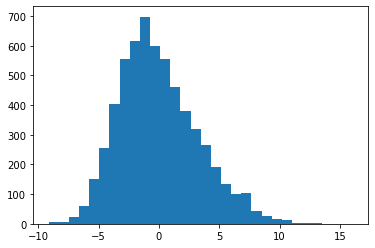

In [31]:
# Plot the hedging costs
plt.hist(nnmodel.predict(x), bins = 30)

In [13]:
preds = nnmodel.predict(x) 

188/188 [==============================] - 2s 11ms/step


In [14]:
np.mean(preds)

-0.017819114

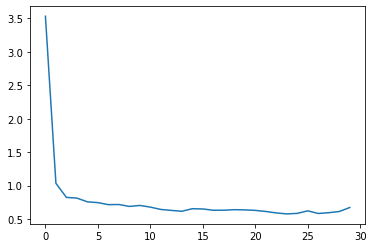

In [15]:
plt.plot(modelhistory.history['loss'])

In [16]:
# plt.plot(Sm[:-1], model.predict(x), marker = '', linestyle = 'none')

188/188 [==============================] - 2s 11ms/step


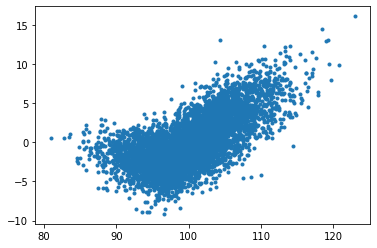

In [17]:
plt.plot(S_a[:, -1], nnmodel.predict(x), marker = ".", linestyle = 'none')
plt.show()

How did I get the chart above to show a option payoff?

## Recurrent Neural Network model

In [18]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = my_input + [premium] + [hedge_cost] + [price] # Input, option premium, hedge cost, asset price *

for j in range(N):

   
    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    delta = tf.expand_dims(delta, axis=0) # Reshape delta for RNN
    delta = tf.keras.layers.LSTM(5)(delta) # First take in asset price 
    delta = tf.keras.layers.Dense(32, activation = 'leaky_relu')(delta) # Then calc delta
    delta = tf.keras.layers.Dropout(0.2)(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)


    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    #info_set = tf.keras.layers.Concatenate()([price, new_price])
    price = new_price

S_average = tf.keras.layers.Input(shape=(1,), name="S_average")
my_input = my_input + [S_average]
    

payoff = tf.keras.layers.Lambda(lambda x : (tf.math.maximum(x-K, 0)))(S_average)  
cum_cost = tf.keras.layers.Add(name="final")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="final_")([cum_cost, premium])

RNNmodel = tf.keras.Model(inputs=my_input, outputs=cum_cost)

In [19]:
RNNmodel.compile(loss='mse', optimizer='adam', metrics = 'accuracy') 

In [20]:
rnnhistory = RNNmodel.fit(x,y, epochs=30, verbose=True)

Epoch 1/30
188/188 [==============================] - 85s 122ms/step - loss: 7.5138 - accuracy: 0.0233
Epoch 2/30
188/188 [==============================] - 27s 146ms/step - loss: 3.0599 - accuracy: 0.0295
Epoch 3/30
188/188 [==============================] - 27s 144ms/step - loss: 2.7491 - accuracy: 0.0232
Epoch 4/30
188/188 [==============================] - 21s 113ms/step - loss: 2.6149 - accuracy: 0.0308
Epoch 5/30
188/188 [==============================] - 22s 116ms/step - loss: 2.5246 - accuracy: 0.0235
Epoch 6/30
188/188 [==============================] - 24s 130ms/step - loss: 2.4356 - accuracy: 0.0238
Epoch 7/30
188/188 [==============================] - 23s 121ms/step - loss: 2.3676 - accuracy: 0.0298
Epoch 8/30
188/188 [==============================] - 22s 119ms/step - loss: 2.3583 - accuracy: 0.0285
Epoch 9/30
188/188 [==============================] - 23s 120ms/step - loss: 2.3119 - accuracy: 0.0282
Epoch 10/30
188/188 [==============================] - 23s 124ms/step - l

188/188 [==============================] - 21s 27ms/step


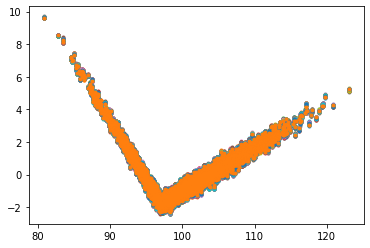

In [21]:
plt.plot(S_a[:, -1], RNNmodel.predict(x), marker = ".", linestyle = 'none')
plt.show()

188/188 [==============================] - 5s 26ms/step


(array([[ 57., 374., 822., 856., 764., 766., 608., 453., 362., 264., 205.,
         128.,  85.,  77.,  43.,  41.,  22.,  22.,  14.,   8.,   7.,   8.,
           5.,   4.,   1.,   0.,   2.,   1.,   0.,   1.],
        [ 68., 353., 843., 849., 765., 753., 611., 458., 358., 271., 208.,
         121.,  86.,  78.,  41.,  41.,  24.,  19.,  17.,   7.,   7.,   9.,
           4.,   4.,   1.,   0.,   2.,   1.,   0.,   1.],
        [ 56., 381., 826., 848., 769., 752., 621., 454., 355., 267., 199.,
         135.,  81.,  78.,  43.,  39.,  22.,  22.,  14.,   9.,   7.,   8.,
           5.,   4.,   1.,   0.,   2.,   1.,   0.,   1.],
        [ 60., 376., 824., 850., 764., 748., 618., 463., 354., 269., 207.,
         125.,  84.,  80.,  40.,  44.,  21.,  21.,  15.,   8.,   7.,   8.,
           5.,   4.,   1.,   1.,   1.,   1.,   0.,   1.],
        [ 59., 377., 827., 849., 772., 734., 630., 464., 347., 262., 213.,
         128.,  86.,  75.,  40.,  41.,  24.,  20.,  15.,   8.,   7.,   9.,
           4.,   4

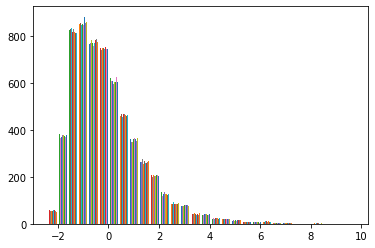

In [22]:
plt.hist(RNNmodel.predict(x), bins = 30)

In [23]:
rnnpreds = np.mean(RNNmodel.predict(x))
rnnpreds

188/188 [==============================] - 5s 28ms/step


-0.05365086

## Convolutional Neural Network model

https://stackoverflow.com/questions/56918388/error-valueerror-the-last-dimension-of-the-inputs-to-dense-should-be-defined

In [24]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = my_input + [premium] + [hedge_cost] + [price] # Input, option premium, hedge cost, asset price *
print("INPUT", my_input)

for j in range(N):
    delta = tf.keras.layers.Dense(32, activation = 'leaky_relu')(price)
    delta = tf.expand_dims(delta, axis=0) # Reshape delta for RNN
    delta = tf.keras.layers.Conv1D(64, kernel_size = 2, activation = 'relu')(delta)
    delta = tf.keras.layers.GlobalMaxPooling1D()(delta)
    delta = tf.keras.layers.Flatten()(delta)
    delta = tf.keras.layers.Dense(32, activation = 'leaky_relu')(delta) # calc delta
    delta = tf.keras.layers.Dropout(0.2)(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    #info_set = tf.keras.layers.Concatenate()([price, new_price])
    price = new_price

S_average = tf.keras.layers.Input(shape=(1,), name="S_average")
my_input = my_input + [S_average]
    
# delta(S1 - S0) + C - premium?
payoff = tf.keras.layers.Lambda(lambda x : (tf.math.maximum(x-K, 0)))(S_average)  
cum_cost = tf.keras.layers.Add(name="final")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="final_")([cum_cost, premium])

CNNmodel = tf.keras.Model(inputs=my_input, outputs=cum_cost)

# tf.keras.utils.plot_model(CNNmodel)
# CNNmodel.summary()

INPUT [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'premium')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'hedge_cost')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'price')>]
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 price (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 dense_560 (Dense)              (None, 32)           64          ['price[0][0]']                  
                                                                                                  
 S0 (InputLayer)                [(None, 1)]          0           []                               
                                                         

 price_inc_0 (Subtract)         (None, 1)            0           ['price[0][0]',                  
                                                                  'S0[0][0]']                     
                                                                                                  
 dropout_161 (Dropout)          (1, 32)              0           ['dense_564[0][0]']              
                                                                                                  
 dense_567 (Dense)              (1, 32)              2080        ['flatten_2[0][0]']              
                                                                                                  
 flatten_3 (Flatten)            (1, 64)              0           ['global_max_pooling1d_3[0][0]'] 
                                                                                                  
 global_max_pooling1d_4 (Global  (1, 64)             0           ['conv1d_4[0][0]']               
 MaxPoolin

 price_inc_3 (Subtract)         (None, 1)            0           ['S2[0][0]',                     
                                                                  'S3[0][0]']                     
                                                                                                  
 dropout_164 (Dropout)          (1, 32)              0           ['dense_573[0][0]']              
                                                                                                  
 dense_576 (Dense)              (1, 32)              2080        ['flatten_5[0][0]']              
                                                                                                  
 flatten_6 (Flatten)            (1, 64)              0           ['global_max_pooling1d_6[0][0]'] 
                                                                                                  
 global_max_pooling1d_7 (Global  (1, 64)             0           ['conv1d_7[0][0]']               
 MaxPoolin

                                                                                                  
 price_inc_6 (Subtract)         (None, 1)            0           ['S5[0][0]',                     
                                                                  'S6[0][0]']                     
                                                                                                  
 dropout_167 (Dropout)          (1, 32)              0           ['dense_582[0][0]']              
                                                                                                  
 dense_585 (Dense)              (1, 32)              2080        ['flatten_8[0][0]']              
                                                                                                  
 flatten_9 (Flatten)            (1, 64)              0           ['global_max_pooling1d_9[0][0]'] 
                                                                                                  
 global_ma

 dense_589 (Dense)              (1, 32)              1056        ['dropout_169[0][0]']            
                                                                                                  
 price_inc_9 (Subtract)         (None, 1)            0           ['S8[0][0]',                     
                                                                  'S9[0][0]']                     
                                                                                                  
 dropout_170 (Dropout)          (1, 32)              0           ['dense_591[0][0]']              
                                                                                                  
 dense_594 (Dense)              (1, 32)              2080        ['flatten_11[0][0]']             
                                                                                                  
 flatten_12 (Flatten)           (1, 64)              0           ['global_max_pooling1d_12[0][0]']
          

                                                                                                  
 dense_598 (Dense)              (1, 32)              1056        ['dropout_172[0][0]']            
                                                                                                  
 price_inc_12 (Subtract)        (None, 1)            0           ['S11[0][0]',                    
                                                                  'S12[0][0]']                    
                                                                                                  
 dropout_173 (Dropout)          (1, 32)              0           ['dense_600[0][0]']              
                                                                                                  
 dense_603 (Dense)              (1, 32)              2080        ['flatten_14[0][0]']             
                                                                                                  
 flatten_1

 stock_14 (Multiply)            (None, 32)           0           ['dense_604[0][0]',              
                                                                  'price_inc_14[0][0]']           
                                                                                                  
 dense_607 (Dense)              (1, 32)              1056        ['dropout_175[0][0]']            
                                                                                                  
 price_inc_15 (Subtract)        (None, 1)            0           ['S14[0][0]',                    
                                                                  'S15[0][0]']                    
                                                                                                  
 dropout_176 (Dropout)          (1, 32)              0           ['dense_609[0][0]']              
                                                                                                  
 dense_612

                                                                                                  
 cost_16 (Add)                  (None, 32)           0           ['cost_15[0][0]',                
                                                                  'stock_16[0][0]']               
                                                                                                  
 stock_17 (Multiply)            (None, 32)           0           ['dense_613[0][0]',              
                                                                  'price_inc_17[0][0]']           
                                                                                                  
 dense_616 (Dense)              (1, 32)              1056        ['dropout_178[0][0]']            
                                                                                                  
 price_inc_18 (Subtract)        (None, 1)            0           ['S17[0][0]',                    
          

                                                                                                  
 dense_641 (Dense)              (None, 32)           64          ['S26[0][0]']                    
                                                                                                  
 S27 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cost_19 (Add)                  (None, 32)           0           ['cost_18[0][0]',                
                                                                  'stock_19[0][0]']               
                                                                                                  
 stock_20 (Multiply)            (None, 32)           0           ['dense_622[0][0]',              
                                                                  'price_inc_20[0][0]']           
          

 conv1d_28 (Conv1D)             (1, None, 64)        4160        ['tf.expand_dims_108[0][0]']     
                                                                                                  
 tf.expand_dims_109 (TFOpLambda  (1, None, 32)       0           ['dense_647[0][0]']              
 )                                                                                                
                                                                                                  
 dense_650 (Dense)              (None, 32)           64          ['S29[0][0]']                    
                                                                                                  
 S30 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cost_22 (Add)                  (None, 32)           0           ['cost_21[0][0]',                
          

                                                                                                  
 global_max_pooling1d_30 (Globa  (1, 64)             0           ['conv1d_30[0][0]']              
 lMaxPooling1D)                                                                                   
                                                                                                  
 conv1d_31 (Conv1D)             (1, None, 64)        4160        ['tf.expand_dims_111[0][0]']     
                                                                                                  
 tf.expand_dims_112 (TFOpLambda  (1, None, 32)       0           ['dense_656[0][0]']              
 )                                                                                                
                                                                                                  
 dense_659 (Dense)              (None, 32)           64          ['S32[0][0]']                    
          

                                                                                                  
 dense_654 (Dense)              (1, 32)              2080        ['flatten_31[0][0]']             
                                                                                                  
 flatten_32 (Flatten)           (1, 64)              0           ['global_max_pooling1d_32[0][0]']
                                                                                                  
 global_max_pooling1d_33 (Globa  (1, 64)             0           ['conv1d_33[0][0]']              
 lMaxPooling1D)                                                                                   
                                                                                                  
 conv1d_34 (Conv1D)             (1, None, 64)        4160        ['tf.expand_dims_114[0][0]']     
                                                                                                  
 tf.expand

 price_inc_32 (Subtract)        (None, 1)            0           ['S31[0][0]',                    
                                                                  'S32[0][0]']                    
                                                                                                  
 dropout_193 (Dropout)          (1, 32)              0           ['dense_660[0][0]']              
                                                                                                  
 dense_663 (Dense)              (1, 32)              2080        ['flatten_34[0][0]']             
                                                                                                  
 flatten_35 (Flatten)           (1, 64)              0           ['global_max_pooling1d_35[0][0]']
                                                                                                  
 global_max_pooling1d_36 (Globa  (1, 64)             0           ['conv1d_36[0][0]']              
 lMaxPooli

                                                                  'price_inc_34[0][0]']           
                                                                                                  
 dense_667 (Dense)              (1, 32)              1056        ['dropout_195[0][0]']            
                                                                                                  
 price_inc_35 (Subtract)        (None, 1)            0           ['S34[0][0]',                    
                                                                  'S35[0][0]']                    
                                                                                                  
 dropout_196 (Dropout)          (1, 32)              0           ['dense_669[0][0]']              
                                                                                                  
 dense_672 (Dense)              (1, 32)              2080        ['flatten_37[0][0]']             
          

 cost_36 (Add)                  (None, 32)           0           ['cost_35[0][0]',                
                                                                  'stock_36[0][0]']               
                                                                                                  
 stock_37 (Multiply)            (None, 32)           0           ['dense_673[0][0]',              
                                                                  'price_inc_37[0][0]']           
                                                                                                  
 dense_676 (Dense)              (1, 32)              1056        ['dropout_198[0][0]']            
                                                                                                  
 price_inc_38 (Subtract)        (None, 1)            0           ['S37[0][0]',                    
                                                                  'S38[0][0]']                    
          

 dense_701 (Dense)              (None, 32)           64          ['S46[0][0]']                    
                                                                                                  
 S47 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cost_39 (Add)                  (None, 32)           0           ['cost_38[0][0]',                
                                                                  'stock_39[0][0]']               
                                                                                                  
 stock_40 (Multiply)            (None, 32)           0           ['dense_682[0][0]',              
                                                                  'price_inc_40[0][0]']           
                                                                                                  
 dense_685

                                                                                                  
 tf.expand_dims_129 (TFOpLambda  (1, None, 32)       0           ['dense_707[0][0]']              
 )                                                                                                
                                                                                                  
 dense_710 (Dense)              (None, 32)           64          ['S49[0][0]']                    
                                                                                                  
 S50 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cost_42 (Add)                  (None, 32)           0           ['cost_41[0][0]',                
                                                                  'stock_42[0][0]']               
          

 global_max_pooling1d_50 (Globa  (1, 64)             0           ['conv1d_50[0][0]']              
 lMaxPooling1D)                                                                                   
                                                                                                  
 conv1d_51 (Conv1D)             (1, None, 64)        4160        ['tf.expand_dims_131[0][0]']     
                                                                                                  
 tf.expand_dims_132 (TFOpLambda  (1, None, 32)       0           ['dense_716[0][0]']              
 )                                                                                                
                                                                                                  
 dense_719 (Dense)              (None, 32)           64          ['S52[0][0]']                    
                                                                                                  
 S53 (Inpu

 dense_714 (Dense)              (1, 32)              2080        ['flatten_51[0][0]']             
                                                                                                  
 flatten_52 (Flatten)           (1, 64)              0           ['global_max_pooling1d_52[0][0]']
                                                                                                  
 global_max_pooling1d_53 (Globa  (1, 64)             0           ['conv1d_53[0][0]']              
 lMaxPooling1D)                                                                                   
                                                                                                  
 conv1d_54 (Conv1D)             (1, None, 64)        4160        ['tf.expand_dims_134[0][0]']     
                                                                                                  
 tf.expand_dims_135 (TFOpLambda  (1, None, 32)       0           ['dense_725[0][0]']              
 )        

                                                                  'S52[0][0]']                    
                                                                                                  
 dropout_213 (Dropout)          (1, 32)              0           ['dense_720[0][0]']              
                                                                                                  
 dense_723 (Dense)              (1, 32)              2080        ['flatten_54[0][0]']             
                                                                                                  
 flatten_55 (Flatten)           (1, 64)              0           ['global_max_pooling1d_55[0][0]']
                                                                                                  
 global_max_pooling1d_56 (Globa  (1, 64)             0           ['conv1d_56[0][0]']              
 lMaxPooling1D)                                                                                   
          

                                                                                                  
 dense_727 (Dense)              (1, 32)              1056        ['dropout_215[0][0]']            
                                                                                                  
 price_inc_55 (Subtract)        (None, 1)            0           ['S54[0][0]',                    
                                                                  'S55[0][0]']                    
                                                                                                  
 dropout_216 (Dropout)          (1, 32)              0           ['dense_729[0][0]']              
                                                                                                  
 dense_732 (Dense)              (1, 32)              2080        ['flatten_57[0][0]']             
                                                                                                  
 flatten_5

                                                                  'stock_56[0][0]']               
                                                                                                  
 stock_57 (Multiply)            (None, 32)           0           ['dense_733[0][0]',              
                                                                  'price_inc_57[0][0]']           
                                                                                                  
 dense_736 (Dense)              (1, 32)              1056        ['dropout_218[0][0]']            
                                                                                                  
 price_inc_58 (Subtract)        (None, 1)            0           ['S57[0][0]',                    
                                                                  'S58[0][0]']                    
                                                                                                  
 dropout_2

                                                                                                  
 S67 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cost_59 (Add)                  (None, 32)           0           ['cost_58[0][0]',                
                                                                  'stock_59[0][0]']               
                                                                                                  
 stock_60 (Multiply)            (None, 32)           0           ['dense_742[0][0]',              
                                                                  'price_inc_60[0][0]']           
                                                                                                  
 dense_745 (Dense)              (1, 32)              1056        ['dropout_221[0][0]']            
          

 tf.expand_dims_149 (TFOpLambda  (1, None, 32)       0           ['dense_767[0][0]']              
 )                                                                                                
                                                                                                  
 dense_770 (Dense)              (None, 32)           64          ['S69[0][0]']                    
                                                                                                  
 S70 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cost_62 (Add)                  (None, 32)           0           ['cost_61[0][0]',                
                                                                  'stock_62[0][0]']               
                                                                                                  
 stock_63 

 lMaxPooling1D)                                                                                   
                                                                                                  
 conv1d_71 (Conv1D)             (1, None, 64)        4160        ['tf.expand_dims_151[0][0]']     
                                                                                                  
 tf.expand_dims_152 (TFOpLambda  (1, None, 32)       0           ['dense_776[0][0]']              
 )                                                                                                
                                                                                                  
 dense_779 (Dense)              (None, 32)           64          ['S72[0][0]']                    
                                                                                                  
 S73 (InputLayer)               [(None, 1)]          0           []                               
          

                                                                                                  
 flatten_72 (Flatten)           (1, 64)              0           ['global_max_pooling1d_72[0][0]']
                                                                                                  
 global_max_pooling1d_73 (Globa  (1, 64)             0           ['conv1d_73[0][0]']              
 lMaxPooling1D)                                                                                   
                                                                                                  
 conv1d_74 (Conv1D)             (1, None, 64)        4160        ['tf.expand_dims_154[0][0]']     
                                                                                                  
 tf.expand_dims_155 (TFOpLambda  (1, None, 32)       0           ['dense_785[0][0]']              
 )                                                                                                
          

                                                                                                  
 dropout_233 (Dropout)          (1, 32)              0           ['dense_780[0][0]']              
                                                                                                  
 dense_783 (Dense)              (1, 32)              2080        ['flatten_74[0][0]']             
                                                                                                  
 flatten_75 (Flatten)           (1, 64)              0           ['global_max_pooling1d_75[0][0]']
                                                                                                  
 global_max_pooling1d_76 (Globa  (1, 64)             0           ['conv1d_76[0][0]']              
 lMaxPooling1D)                                                                                   
                                                                                                  
 conv1d_77

                                                                                                  
 cost_74 (Add)                  (None, 32)           0           ['cost_73[0][0]',                
                                                                  'stock_74[0][0]']               
                                                                                                  
 stock_75 (Multiply)            (None, 32)           0           ['dense_787[0][0]',              
                                                                  'price_inc_75[0][0]']           
                                                                                                  
 dense_790 (Dense)              (1, 32)              1056        ['dropout_236[0][0]']            
                                                                                                  
 price_inc_76 (Subtract)        (None, 1)            0           ['S75[0][0]',                    
          

In [25]:
CNNmodel.compile(loss='mse', optimizer = 'adam', metrics = 'accuracy')

In [26]:
cnnhistory = CNNmodel.fit(x,y, epochs=30, verbose=True)

Epoch 1/30
188/188 [==============================] - 17s 22ms/step - loss: 211.6745 - accuracy: 0.0348
Epoch 2/30
188/188 [==============================] - 4s 22ms/step - loss: 15.1230 - accuracy: 0.0355
Epoch 3/30
188/188 [==============================] - 5s 27ms/step - loss: 10.1948 - accuracy: 0.0278
Epoch 4/30
188/188 [==============================] - 5s 27ms/step - loss: 8.1553 - accuracy: 0.0318
Epoch 5/30
188/188 [==============================] - 5s 27ms/step - loss: 7.0148 - accuracy: 0.0288
Epoch 6/30
188/188 [==============================] - 5s 27ms/step - loss: 6.2785 - accuracy: 0.0297
Epoch 7/30
188/188 [==============================] - 5s 27ms/step - loss: 5.6734 - accuracy: 0.0297
Epoch 8/30
188/188 [==============================] - 5s 28ms/step - loss: 5.3037 - accuracy: 0.0263
Epoch 9/30
188/188 [==============================] - 6s 32ms/step - loss: 4.9749 - accuracy: 0.0293
Epoch 10/30
188/188 [==============================] - 5s 26ms/step - loss: 4.6134 - a

188/188 [==============================] - 3s 7ms/step


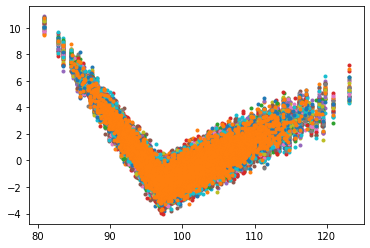

In [27]:
plt.plot(S_a[:, -1], CNNmodel.predict(x), marker = ".", linestyle = 'none')
plt.show()

188/188 [==============================] - 2s 9ms/step


(array([[  1.,  11.,  62., 216., 528., 802., 945., 852., 735., 558., 421.,
         280., 210., 124.,  82.,  57.,  36.,  27.,  22.,   8.,   3.,   6.,
           6.,   4.,   1.,   2.,   0.,   0.,   1.,   0.],
        [  0.,   0.,  27., 182., 505., 878., 987., 889., 694., 563., 436.,
         287., 178., 128.,  81.,  51.,  41.,  21.,  20.,   7.,   9.,   5.,
           6.,   2.,   1.,   1.,   0.,   0.,   1.,   0.],
        [  0.,   2.,  29., 174., 513., 872., 974., 916., 736., 569., 398.,
         288., 166., 121.,  70.,  53.,  28.,  30.,  21.,  13.,   8.,   7.,
           2.,   5.,   2.,   2.,   0.,   0.,   0.,   1.],
        [  2.,   5.,  51., 202., 534., 829., 911., 893., 699., 590., 396.,
         306., 192., 136.,  86.,  50.,  42.,  26.,  18.,  11.,   3.,   8.,
           4.,   2.,   1.,   2.,   0.,   0.,   0.,   1.],
        [  0.,   3.,  40., 172., 526., 887., 926., 925., 717., 590., 395.,
         265., 187., 105.,  72.,  53.,  39.,  30.,  22.,  16.,  11.,   6.,
           5.,   4

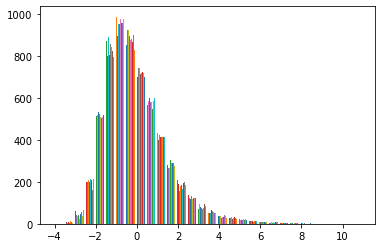

In [28]:
plt.hist(CNNmodel.predict(x), bins = 30)

In [29]:
cnnpreds = np.mean(CNNmodel.predict(x))
cnnpreds

188/188 [==============================] - 2s 9ms/step


-0.057973612

In [30]:
CNNmodel.predict(x)

188/188 [==============================] - 2s 9ms/step


array([[-2.0161762e+00, -1.9965351e+00, -2.0093215e+00, ...,
        -2.5134058e+00, -2.3917775e+00, -2.3814442e+00],
       [ 2.7063391e+00,  2.7760346e+00,  2.0550997e+00, ...,
         2.6228101e+00,  2.5699866e+00,  2.7669818e+00],
       [-5.8951592e-01, -6.6287303e-01, -9.4252729e-01, ...,
         1.9717193e-01, -5.7362771e-01, -1.8509388e-01],
       ...,
       [ 1.4067261e+00,  1.7983072e+00,  1.0458639e+00, ...,
         7.9240489e-01,  4.9868751e-01,  1.0383651e+00],
       [ 7.9334235e-01,  7.2026801e-01,  4.4607282e-01, ...,
         4.5786214e-01, -1.6534543e-01,  1.2788632e+00],
       [-3.9617372e-01, -5.9934878e-01, -2.2872782e-01, ...,
        -1.7009902e-01,  1.6304326e-01, -1.7936230e-03]], dtype=float32)